# 3D spatial transcriptomics Interpolation

This notebook demonstrates the process of continuous expression pattern learning in the 3D volume model. Spateo contains the following four interpolation methods:

1. The methods (Shepard, Gaussian and Linear) contained in the VTK;
2. A new Gaussian Process method;
3. The SparseVFC method contained in the Dynamo;
4. A new Deep Learning method.

In [1]:
import warnings
import numpy as np
import spateo as st
import dynamo as dyn
warnings.filterwarnings("ignore")

2023-07-26 17:47:26.236300: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load the data


In [3]:
cpo = [(553, 1098, 277), (1.967, -6.90, -2.21), (0, 0, 1)]

adata = st.sample_data.drosophila(filename="E7-9h_cellbin.h5ad")
adata.uns["pp"] = {}
adata.uns["__type"] = "UMI"
dyn.pp.normalize(adata)
dyn.pp.log1p(adata)
adata

AnnData object with n_obs × n_vars = 25921 × 8136
    obs: 'area', 'slices', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'counts_X_Size_Factor', 'initial_counts_X_cell_size', 'Size_Factor', 'initial_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size'
    uns: 'pp', '__type'
    obsm: '3d_align_spatial'
    layers: 'counts_X', 'spliced', 'unspliced', 'X_spliced', 'X_counts_X', 'X_unspliced'

In [4]:
# Down-sampling
from dynamo.tools import sample
sampling = sample(arr=np.asarray(adata.obs_names), n=10000, method="random", X=adata.obsm["3d_align_spatial"])
adata = adata[sampling, :]

## Reconstruct the voxel model corresponding to the 3D spatial transcriptomics data

See also [3D Reconstruction](./3D%20Reconstruction.ipynb) for more details on 3D reconstructed models.

In [5]:
# Reconstruct point cloud model
pc, plot_cmap = st.tdr.construct_pc(adata=adata.copy(), spatial_key="3d_align_spatial", groupby="anno_tissue")

# Reconstruct mesh model
mesh, _, _ = st.tdr.construct_surface(pc=pc, alpha=0.6, cs_method="marching_cube", cs_args={"mc_scale_factor": 1.0}, smooth=5000, scale_factor=1.)

# Reconstruct voxel model
voxel, _ = st.tdr.voxelize_mesh(mesh=mesh, voxel_pc=pc, smooth=50)
voxel

UnstructuredGrid,Information
N Cells,17237
N Points,18780
X Bounds,"-2.588e+02, 2.593e+02"
Y Bounds,"-1.092e+02, 9.780e+01"
Z Bounds,"-9.657e+01, 8.376e+01"
N Arrays,0


## The raw gene expression patterns in the point cloud model



In [6]:
genes = ["Bacc", "HmgD", "Ance"]

# Add gene expression matrix to the point cloud model
pc_index=pc.point_data["obs_index"].tolist()
for gene_name in genes:
    exp = adata[pc_index, gene_name].X.flatten()
    st.tdr.add_model_labels(model=pc, labels=exp, key_added=gene_name, where="point_data",inplace=True)

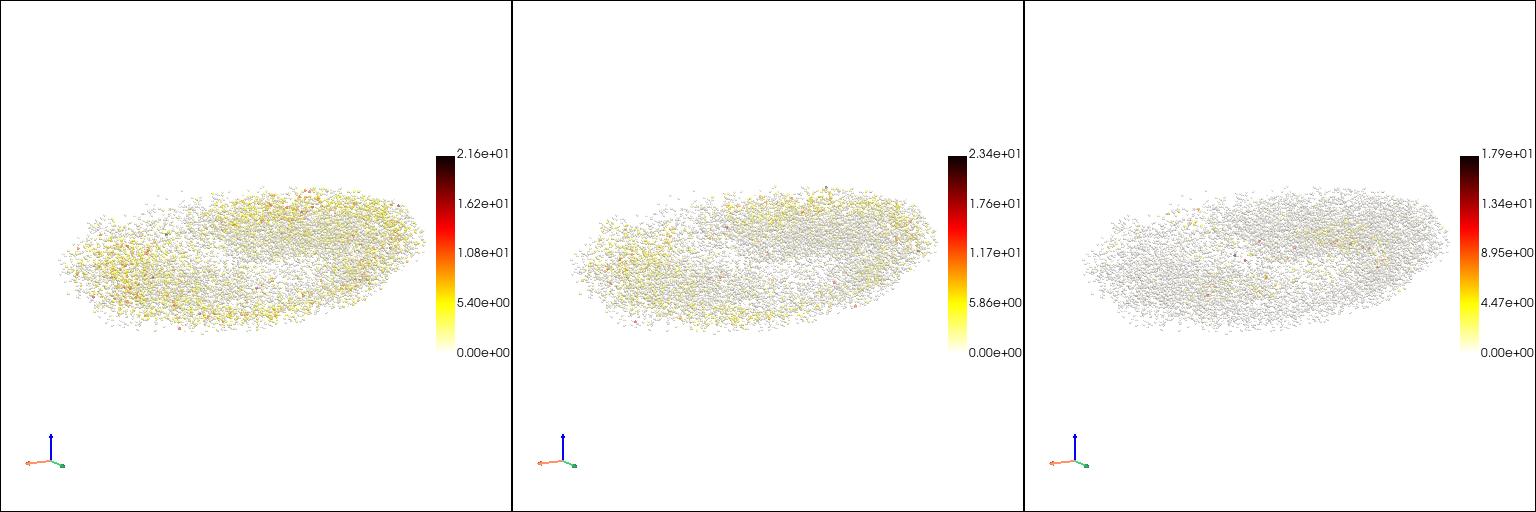

In [7]:
st.pl.three_d_multi_plot(
    model=pc,
    key=genes,
    colormap="hot_r",
    opacity=0.5,
    model_style="points",
    jupyter="static",
    cpo=[cpo]
)

## Learn a continuous mapping from space to gene expression pattern with the method contained in VTK

In [8]:
interpolated_vtk_adata = st.tdr.vtk_interpolation(source_adata=adata.copy(), spatial_key="3d_align_spatial", keys=genes, target_points=np.asarray(voxel.points), n_points=5)
interpolated_vtk_adata

|-----> Creating an adata object with the interpolated expression...
|-----> [VTKInterpolation] in progress: 100.0000%
|-----> [VTKInterpolation] finished [72.5322s]


AnnData object with n_obs × n_vars = 18780 × 3
    obsm: '3d_align_spatial'

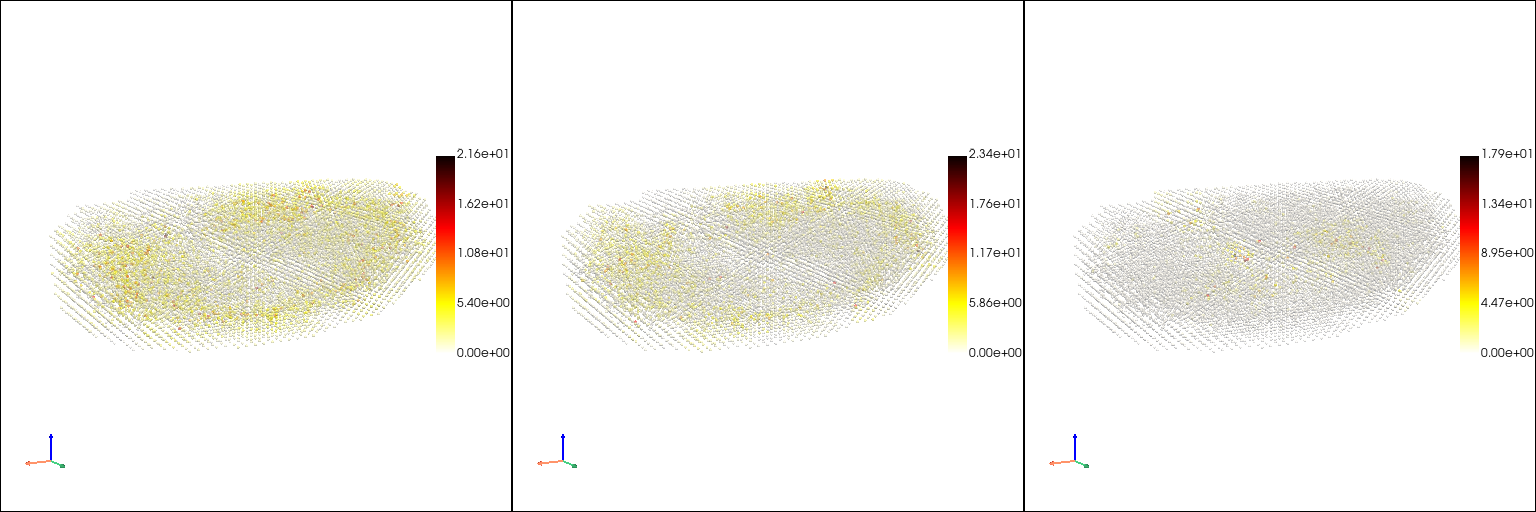

In [9]:
interpolated_vtk_pc, _ = st.tdr.construct_pc(adata=interpolated_vtk_adata.copy(), spatial_key="3d_align_spatial", groupby=genes[0])
_pc_index=interpolated_vtk_pc.point_data["obs_index"].tolist()
for gene_name in genes[1:]:
    _exp = interpolated_vtk_adata[_pc_index, gene_name].X.flatten()
    st.tdr.add_model_labels(model=interpolated_vtk_pc, labels=_exp, key_added=gene_name, where="point_data",inplace=True)

st.pl.three_d_multi_plot(
    model=interpolated_vtk_pc,
    key=genes,
    colormap="hot_r",
    opacity=0.5,
    model_style="points",
    jupyter="static",
    cpo=[cpo]
)

 ## Learn a continuous mapping from space to gene expression pattern with the Gaussian Process method


In [10]:
interpolated_gp_adata = st.tdr.gp_interpolation(source_adata=adata.copy(), spatial_key="3d_align_spatial", keys=genes, target_points=np.asarray(voxel.points), device="cpu")
interpolated_gp_adata

|-----> [Gaussian Process Regression] in progress: 100.0000%
|-----> [Gaussian Process Regression] finished [176.5625s]
|-----> Creating an adata object with the interpolated expression...
|-----> [GaussianProcessInterpolation] in progress: 100.0000%
|-----> [GaussianProcessInterpolation] finished [193.5424s]


AnnData object with n_obs × n_vars = 18780 × 3
    obsm: '3d_align_spatial'

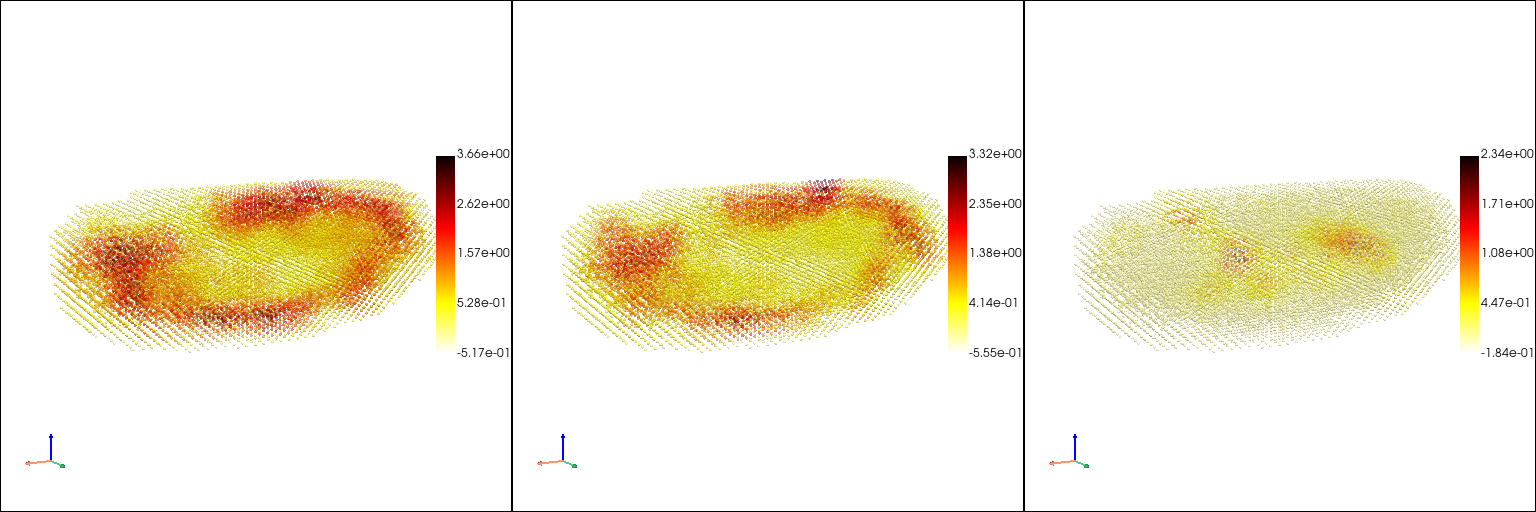

In [11]:
interpolated_gp_pc, _ = st.tdr.construct_pc(adata=interpolated_gp_adata.copy(), spatial_key="3d_align_spatial", groupby=genes[0])
_pc_index=interpolated_gp_pc.point_data["obs_index"].tolist()
for gene_name in genes[1:]:
    _exp = interpolated_gp_adata[_pc_index, gene_name].X.flatten()
    st.tdr.add_model_labels(model=interpolated_gp_pc, labels=_exp, key_added=gene_name, where="point_data",inplace=True)

st.pl.three_d_multi_plot(
    model=interpolated_gp_pc,
    key=genes,
    colormap="hot_r",
    opacity=0.5,
    model_style="points",
    jupyter="static",
    cpo=[cpo]
)

## Learn a continuous mapping from space to gene expression pattern with sparseVFC method

In [12]:
interpolated_svfc_adata = st.tdr.kernel_interpolation(source_adata=adata.copy(), spatial_key="3d_align_spatial", keys=genes, target_points=np.asarray(voxel.points))
interpolated_svfc_adata

|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] completed [0.3751s]
|-----> Creating an adata object with the interpolated expression...
|-----> [KernelInterpolation] in progress: 100.0000%
|-----> [KernelInterpolation] finished [0.9768s]


AnnData object with n_obs × n_vars = 18780 × 3
    obsm: '3d_align_spatial'

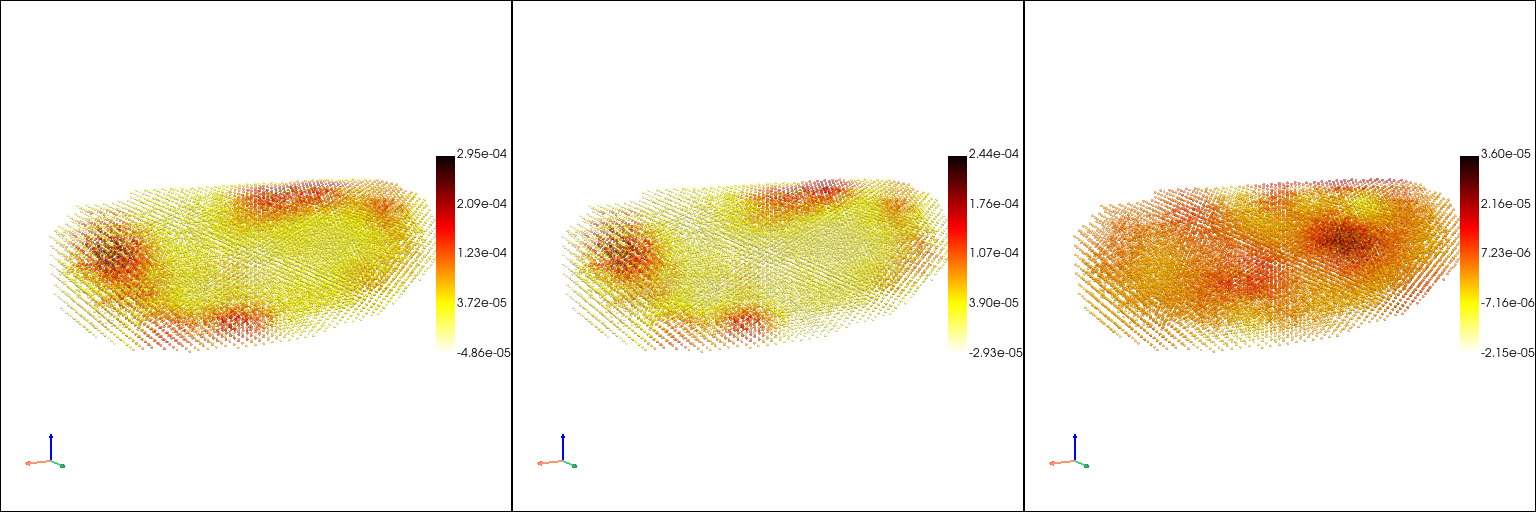

In [13]:
interpolated_svfc_pc, _ = st.tdr.construct_pc(adata=interpolated_svfc_adata.copy(), spatial_key="3d_align_spatial", groupby=genes[0])
_pc_index=interpolated_svfc_pc.point_data["obs_index"].tolist()
for gene_name in genes[1:]:
    _exp = interpolated_svfc_adata[_pc_index, gene_name].X.flatten()
    st.tdr.add_model_labels(model=interpolated_svfc_pc, labels=_exp, key_added=gene_name, where="point_data",inplace=True)

st.pl.three_d_multi_plot(
    model=interpolated_svfc_pc,
    key=genes,
    colormap="hot_r",
    opacity=0.5,
    model_style="points",
    jupyter="static",
    cpo=[cpo]
)

## Learn a continuous mapping from space to gene expression pattern with deep learning method

In [14]:
interpolated_deep_adata = st.tdr.deep_intepretation(source_adata=adata.copy(), spatial_key="3d_align_spatial", keys=genes, target_points=np.asarray(voxel.points))
interpolated_deep_adata

Iter [     100] Time [9.8011] regression loss [8.0909] autoencoder loss [nan]
Model saved in path: model_buffer/
Iter [     200] Time [18.7046] regression loss [8.7426] autoencoder loss [nan]
Model saved in path: model_buffer/
Iter [     300] Time [27.0023] regression loss [8.3314] autoencoder loss [nan]
Model saved in path: model_buffer/
Iter [     400] Time [36.9290] regression loss [8.4856] autoencoder loss [nan]
Model saved in path: model_buffer/
Iter [     500] Time [45.0048] regression loss [8.3843] autoencoder loss [nan]
Model saved in path: model_buffer/
Iter [     600] Time [53.7922] regression loss [8.7756] autoencoder loss [nan]
Model saved in path: model_buffer/
Iter [     700] Time [63.0616] regression loss [9.2791] autoencoder loss [nan]
Model saved in path: model_buffer/
Iter [     800] Time [72.5802] regression loss [9.0534] autoencoder loss [nan]
Model saved in path: model_buffer/
Iter [     900] Time [82.7186] regression loss [8.4884] autoencoder loss [nan]
Model save

AnnData object with n_obs × n_vars = 18780 × 3
    obsm: '3d_align_spatial'

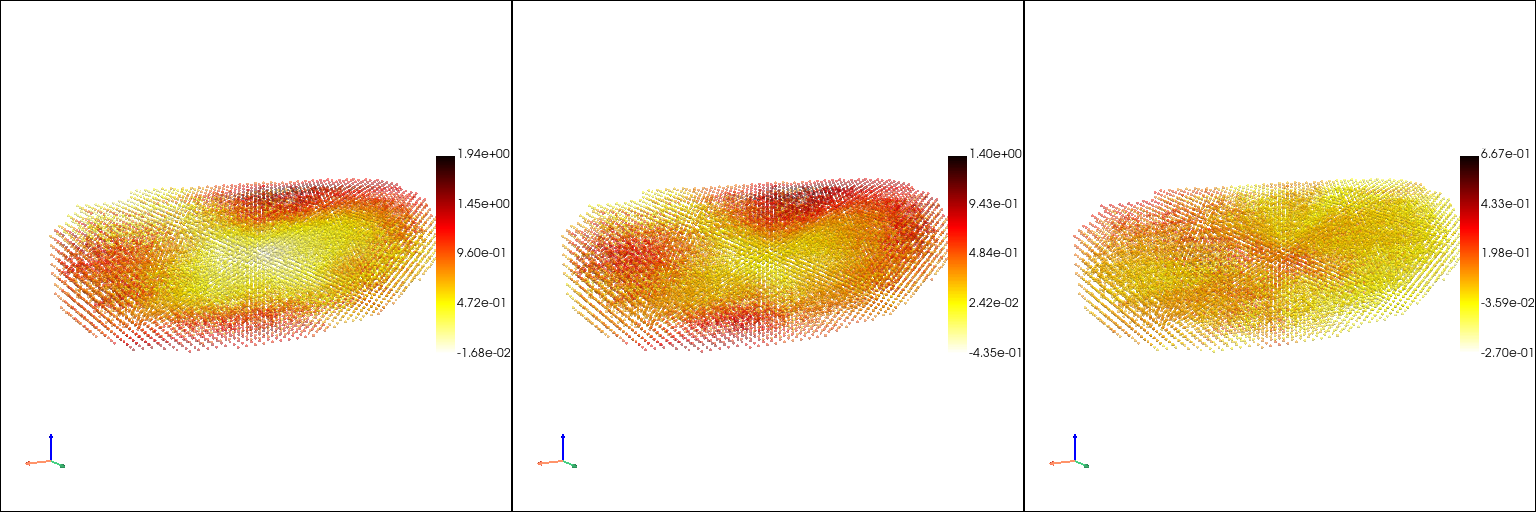

In [15]:
interpolated_deep_pc, _ = st.tdr.construct_pc(adata=interpolated_deep_adata.copy(), spatial_key="3d_align_spatial", groupby=genes[0])
_pc_index=interpolated_deep_pc.point_data["obs_index"].tolist()
for gene_name in genes[1:]:
    _exp = interpolated_deep_adata[_pc_index, gene_name].X.flatten()
    st.tdr.add_model_labels(model=interpolated_deep_pc, labels=_exp, key_added=gene_name, where="point_data",inplace=True)

st.pl.three_d_multi_plot(
    model=interpolated_deep_pc,
    key=genes,
    colormap="hot_r",
    opacity=0.5,
    model_style="points",
    jupyter="static",
    cpo=[cpo]
)

##  Slice the voxel model to observe the gene expression inside the model

In [16]:
for gene_name in genes:
    voxel.point_data[gene_name] = np.asarray(interpolated_gp_adata[:, gene_name].X)

voxel_slices_x = st.tdr.three_d_slice(model=voxel, method="axis", n_slices=15, axis="x")

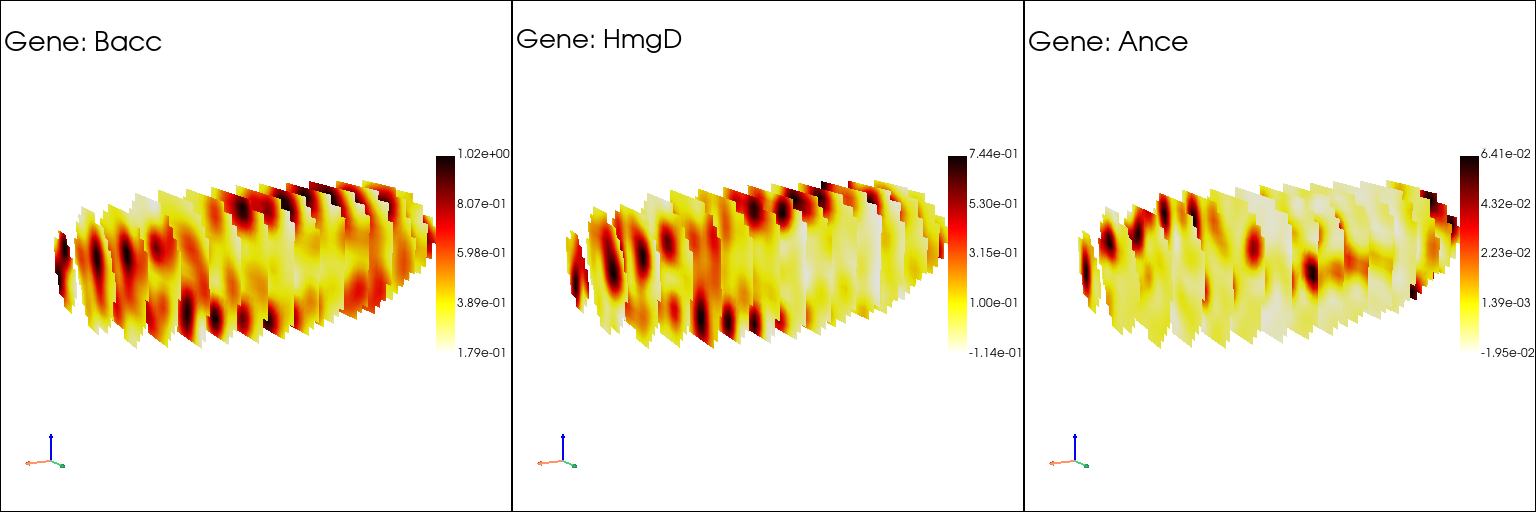

In [31]:
st.pl.three_d_multi_plot(
    model=st.tdr.collect_models([voxel_slices_x]),
    key=genes,
    model_style="surface",
    colormap="hot_r",
    ambient=0.5,
    jupyter="static",
    cpo=[cpo],
    shape=(1, 3),
    text=[f"\nGene: {gene_name}\n" for gene_name in genes],
    text_kwargs={"text_size": 15, "text_font": "arial"},
)